In [1]:
import os
import sys
import copy
import random
from datetime import datetime

import numpy as np
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from tqdm.notebook import tqdm
from IPython.display import display
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim, cuda
from torch.utils.data import DataLoader, Dataset


from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report


# This is PyTorch implementation of Mamba taken from https://github.com/alxndrTL/mamba.py
from model.mamba import MambaConfig, Mamba

In [2]:
ROOT_PATH = './'
DRIVE_PATH = 'Colab/TimeSeries-TP2'

# When on Colab, use Google Drive as the root path to persist and load data
if 'google.colab' in sys.modules:
    from google.colab import drive, output
    output.enable_custom_widget_manager()

    drive.mount('/content/drive')
    ROOT_PATH = os.path.join('/content/drive/My Drive/', DRIVE_PATH)
    os.makedirs(ROOT_PATH, exist_ok=True)
    os.chdir(ROOT_PATH)

In [3]:
SEED = hash("AHHHHHHHHHHHHHHHHHHHHHHHHHH") % (2 ** 32 - 1)

ROCKET_BATCH_SIZE = 1024
BATCH_SIZE = 256
MAX_SEQUENCE_LENGTH = 5 * 128 # 5 seconds of 128Hz signal

TOTAL_EPOCHS = 100

BETA_1 = 0.9
BETA_2 = 0.999
EPS = 1e-8
AMSGRAD = False
WEIGHT_DECAY = 0.01

LEARNING_RATE = 0.001
WARMUP_RATIO = 0.1


PYTORCH_DEVICE = 'cpu'

# Use NVIDIA GPU if available
if cuda.is_available():
    PYTORCH_DEVICE = 'cuda'

# Use Apple Metal backend if available
if torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("Your device supports MPS but it is not installed. Checkout https://developer.apple.com/metal/pytorch/")
    else:
        PYTORCH_DEVICE = 'mps'


print (f"Using {PYTORCH_DEVICE} device for PyTorch")

Using cuda device for PyTorch


In [4]:
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.mps.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
balanced_df = pl.read_parquet("./data/balanced.pqt.zst")
display(balanced_df.sample(10, seed=SEED))

record,fs,signal,label
i64,i64,"array[f64, 640]",bool
103,128,"[-0.30628, -0.3211, … 0.42978]",false
23,128,"[-0.0988, -0.0988, … 0.30134]",true
23,128,"[-0.08398, -0.05928, … -0.12844]",true
122,128,"[-0.10868, -0.09386, … -0.10868]",false
204,128,"[0.811061, 1.137001, … -0.00758]",true
22,128,"[0.59774, 0.676781, … 0.09386]",false
103,128,"[-0.0988, -0.08892, … 0.0494]",true
103,128,"[-0.14326, -0.12844, … 0.00494]",true
116,128,"[-0.23994, -0.25327, … -0.22661]",true


In [6]:
train_df, test_df = train_test_split(balanced_df, test_size=0.2)
val_df, test_df = train_test_split(test_df, test_size=0.5)

print(f"Train count: {train_df.shape[0]}")
print(f"Val count: {val_df.shape[0]}")
print(f"Test count: {test_df.shape[0]}")

Train count: 99920
Val count: 12490
Test count: 12490


In [7]:
scaler = None

In [8]:
class MambaDataset(Dataset):
    def __init__(self, df: pl.DataFrame, scaler: MinMaxScaler | StandardScaler | None = None):
        self.signals = df['signal'].to_numpy().copy().astype(np.float32)
        if scaler is not None:
            self.signals = scaler.transform(self.signals)
        self.labels = df['label'].to_numpy().copy().astype(np.float32)
    
    def __len__(self):
        return len(self.signals)
    
    def __getitem__(self, idx):
        return self.signals[idx], self.labels[idx]

train_dataloader = DataLoader(MambaDataset(train_df, scaler), batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_dataloader = DataLoader(MambaDataset(val_df, scaler), batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_dataloader = DataLoader(MambaDataset(test_df, scaler), batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [9]:
class PointWiseFFN(nn.Module):
    def __init__(self, hidden_dim: int) -> None:
        super().__init__()

        self.W1 = nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.W2 = nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x_1 = self.relu(self.W1(x))
        x_2 = self.W2(x_1)
        return x_2


class MambaClassifier(nn.Module):
    def __init__(self, input_size = 640, hidden_dim=256, classifier_dim = 128, encoder_dropout=0.5, classifier_dropout = 0.5):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Linear(input_size, hidden_dim),
            nn.Dropout(encoder_dropout),
        )

        self.mamba = Mamba(MambaConfig(d_model=hidden_dim, n_layers=1))

        self.ffnn = PointWiseFFN(hidden_dim)
        self.ffnn_norm = nn.LayerNorm(normalized_shape=hidden_dim)
        self.ffnn_dropout = nn.Dropout(classifier_dropout)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, classifier_dim),
            nn.ReLU(),
            nn.LayerNorm(normalized_shape=classifier_dim),
            nn.Dropout(classifier_dropout),
            
            nn.Linear(classifier_dim, 1),
        )

    def forward(self, x):
        # Apply encoder
        x = x.unsqueeze(1)
        x = self.enc(x)

        # Apply Mamba
        x = self.mamba(x)

        # Apply FFNN
        ffn = self.ffnn(x)
        x = self.ffnn_norm(ffn + x) # Residual connection
        x = self.ffnn_dropout(x)

        # Apply classifier
        logits = self.classifier(x)
        return logits

In [10]:
model = MambaClassifier(input_size=balanced_df['signal'].dtype.shape[0])
model.to(PYTORCH_DEVICE)

bce_criterion = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, betas=(BETA_1, BETA_2), eps=EPS, weight_decay=WEIGHT_DECAY, amsgrad=AMSGRAD)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer=optimizer,
    max_lr=LEARNING_RATE,
    total_steps=TOTAL_EPOCHS * len(train_dataloader),
    pct_start=WARMUP_RATIO,
    anneal_strategy="linear",
)


def evaluate():
    model.eval()
    preds_y = []
    true_y = []
    for _, batch in tqdm(enumerate(val_dataloader), desc="Batches", unit="Batch", total=len(val_dataloader), leave=False):
        x, y = batch
        x = x.to(PYTORCH_DEVICE)
        y = y.to(PYTORCH_DEVICE)
        y_hat = model(x).squeeze()
        y_hat = torch.sigmoid(y_hat)
        preds_y.append(y_hat.detach().cpu().numpy())
        true_y.append(y.detach().cpu().numpy())

    preds_y = np.concatenate(preds_y) > 0.5
    true_y = np.concatenate(true_y) > 0.5

    return f1_score(true_y, preds_y, average="macro")

def train():
    train_losses = []
    eval_scores = []
    learning_rates = []
    best_model_state_dict = None
    best_model_score = 0


    fig_loss_widget = go.FigureWidget(layout=go.Layout(title="Loss"))
    fig_f1_widget = go.FigureWidget(layout=go.Layout(title="Macro F1-Score"))
    fig_lr_widget = go.FigureWidget(layout=go.Layout(title="Learning Rate"))


    fig_loss_widget.add_scatter(x=np.arange(len(train_losses)) + 1, y=train_losses)
    fig_f1_widget.add_scatter(x=np.arange(len(eval_scores)) + 1, y=eval_scores)
    fig_lr_widget.add_scatter(x=np.arange(len(learning_rates)) + 1, y=learning_rates)

    fig_loss_widget.update_xaxes(title_text='Epoch')
    fig_f1_widget.update_xaxes(title_text='Epoch')
    fig_lr_widget.update_xaxes(title_text='Epoch')
    
    fig_loss_widget.update_yaxes(title_text='Loss')
    fig_f1_widget.update_yaxes(title_text='F1-Score')
    fig_lr_widget.update_yaxes(title_text='Learning Rate')

    display(fig_lr_widget)
    display(fig_loss_widget)
    display(fig_f1_widget)

    
    for _ in tqdm(range(TOTAL_EPOCHS), desc="Training", unit="Epoch"):
        model.train()
        train_loss = 0

        learning_rates.append(optimizer.param_groups[0]["lr"])

        for _, batch in tqdm(enumerate(train_dataloader), desc="Batches", unit="Batch", total=len(train_dataloader), leave=False):
            optimizer.zero_grad()
            x, y = batch
            x = x.to(PYTORCH_DEVICE)
            y = y.to(PYTORCH_DEVICE)
            y_hat = model(x).squeeze()

            loss = bce_criterion(y_hat, y)

            loss.backward()
            train_loss += loss.item()

            optimizer.step()
            scheduler.step()


        eval_score = evaluate()

        eval_scores.append(eval_score)
        train_losses.append(train_loss / len(train_dataloader))

        fig_loss_widget.data[0].x = np.arange(len(train_losses)) + 1
        fig_loss_widget.data[0].y = train_losses
        fig_f1_widget.data[0].x = np.arange(len(eval_scores)) + 1
        fig_f1_widget.data[0].y = eval_scores
        fig_lr_widget.data[0].x= np.arange(len(learning_rates)) + 1
        fig_lr_widget.data[0].y = learning_rates

        if eval_score > best_model_score:
            best_model_score = eval_score
            best_model_state_dict = copy.deepcopy(model.state_dict())

    return train_losses, eval_scores, best_model_state_dict

train_losses, eval_scores, best_model_state_dict = train()

FigureWidget({
    'data': [{'type': 'scatter', 'uid': '04fb6326-feee-45df-8d1e-83b07deda1c1', 'x': array([], dtype=int64), 'y': []}],
    'layout': {'template': '...',
               'title': {'text': 'Learning Rate'},
               'xaxis': {'title': {'text': 'Epoch'}},
               'yaxis': {'title': {'text': 'Learning Rate'}}}
})

FigureWidget({
    'data': [{'type': 'scatter', 'uid': 'df4ddf60-1c3e-4602-a03d-8f5679e724eb', 'x': array([], dtype=int64), 'y': []}],
    'layout': {'template': '...',
               'title': {'text': 'Loss'},
               'xaxis': {'title': {'text': 'Epoch'}},
               'yaxis': {'title': {'text': 'Loss'}}}
})

FigureWidget({
    'data': [{'type': 'scatter', 'uid': '80bc4e19-db7a-4ce5-9352-ed4eac3398bc', 'x': array([], dtype=int64), 'y': []}],
    'layout': {'template': '...',
               'title': {'text': 'Macro F1-Score'},
               'xaxis': {'title': {'text': 'Epoch'}},
               'yaxis': {'title': {'text': 'F1-Score'}}}
})

Training:   0%|          | 0/100 [00:00<?, ?Epoch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/391 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/49 [00:00<?, ?Batch/s]

In [11]:
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
os.makedirs(f"models/mamba-cls/{timestamp}/", exist_ok=True)
torch.save(best_model_state_dict, f"models/mamba-cls/{timestamp}/mlp.pt")

In [12]:
test_model = MambaClassifier(input_size=balanced_df['signal'].dtype.shape[0])
test_model.to(PYTORCH_DEVICE)
test_model.load_state_dict(best_model_state_dict)

<All keys matched successfully>

Predicting:   0%|          | 0/49 [00:00<?, ?Batch/s]

              precision    recall  f1-score   support

       False       0.74      0.78      0.76      6303
        True       0.77      0.72      0.74      6187

    accuracy                           0.75     12490
   macro avg       0.75      0.75      0.75     12490
weighted avg       0.75      0.75      0.75     12490



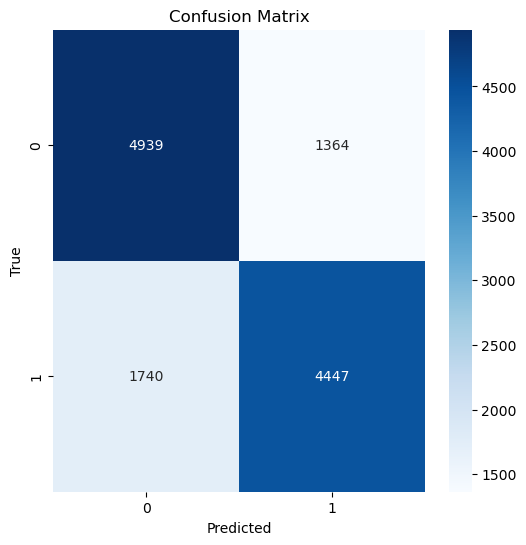

In [13]:
test_pred_y = []
test_true_y = []

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Predicting", unit="Batch", total=len(test_dataloader)):
        x, y = batch
        x = x.to(PYTORCH_DEVICE)
        y_hat = test_model(x).squeeze()
        test_pred_y.append(y_hat.cpu().numpy())
        test_true_y.append(y.cpu().numpy())

test_pred_y = np.concatenate(test_pred_y) > 0.5
test_true_y = np.concatenate(test_true_y) > 0.5

rep = classification_report(test_true_y, test_pred_y)
print(rep)
cm = confusion_matrix(test_true_y, test_pred_y)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

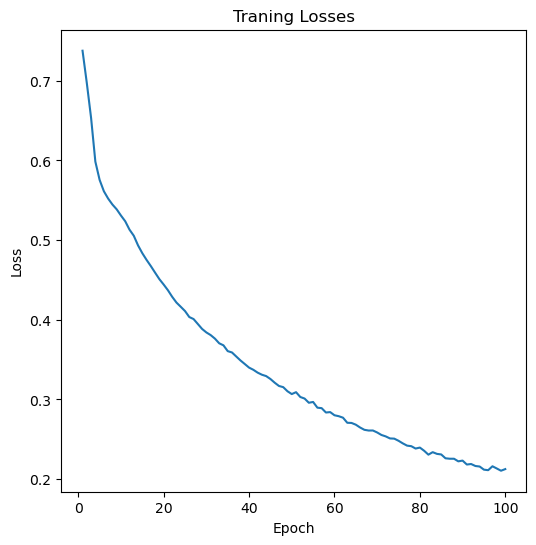

In [14]:
plt.figure(figsize=(6, 6))
sns.lineplot(x=np.arange(len(train_losses)) + 1, y=train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Traning Losses')
plt.show()

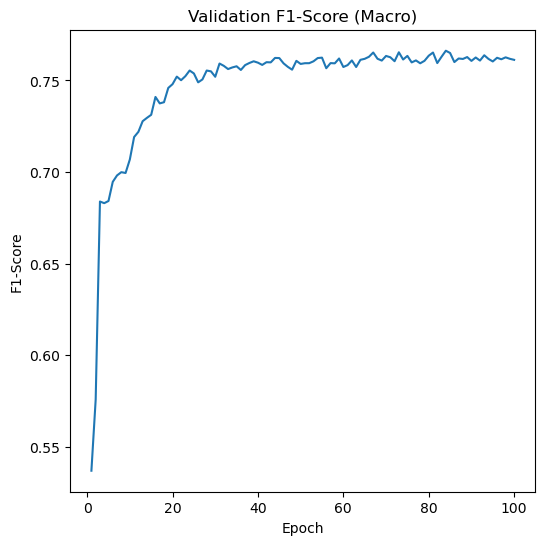

In [15]:
plt.figure(figsize=(6, 6))
sns.lineplot(x=np.arange(len(eval_scores)) + 1, y=eval_scores)
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('Validation F1-Score (Macro)')
plt.show()